In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, auc, precision_score, roc_auc_score, accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# Experiments block
import wandb


pd.set_option('display.max_columns', None)

In [3]:
# Подготовим инфраструктуру для версионирования экспериментов
project_name = "Makarov_mfdp_unit_5"
exp_name = "exp_"
config = []

## Эксперимент 3 Feature Importance via mRMR (FCQ) and sequent feature selection
Идея аналогична предыдущей, только в этом случае мы возьмём алгоритм, выбирающий K лучших фич, где K - устанавливаемый вручную минимум.  Нужно провести эксперименты вокруг 20 фич, чтобы понять возможное влияние на итоговые метрики

https://github.com/smazzanti/mrmr

https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b

In [6]:
outliers_data = pd.read_csv("1_outliers_raw_data")
outliers_data.shape

(21897, 493)

In [32]:
# 20 фич

X = outliers_data.drop(columns=["TARGET", "SK_ID_CURR"])
y = outliers_data["TARGET"]

from mrmr import mrmr_classif
selected_features = mrmr_classif(X=X, y=y, K=20)

print(selected_features)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]

['EXT_SOURCE_3', 'FLOORSMAX_AVG', 'EXT_SOURCE_2', 'prev_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_count_norm', 'EXT_SOURCE_1', 'prev_NAME_CASH_LOAN_PURPOSE_Urgent needs_count', 'prev_PRODUCT_COMBINATION_Cash X-Sell: high_count', 'bureau_CREDIT_TYPE_Microloan_count_norm', 'bureau_CREDIT_ACTIVE_Active_count', 'prev_CODE_REJECT_REASON_SCOFR_count', 'prev_DAYS_FIRST_DRAWING_mean', 'prev_NAME_TYPE_SUITE_Group of people_count', 'prev_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_count', 'ORGANIZATION_TYPE_Self-employed', 'FLAG_OWN_CAR', 'prev_NAME_PRODUCT_TYPE_walk-in_count', 'AMT_ANNUITY', 'prev_PRODUCT_COMBINATION_Cash X-Sell: middle_count_norm', 'bureau_DAYS_CREDIT_ENDDATE_sum', 'OWN_CAR_AGE']


Learning rate set to 0.129448
0:	test: 0.7289080	best: 0.7289080 (0)	total: 5.31ms	remaining: 1.06s
100:	test: 0.7725734	best: 0.7779361 (79)	total: 497ms	remaining: 487ms
199:	test: 0.7631942	best: 0.7779361 (79)	total: 995ms	remaining: 0us

bestTest = 0.7779360775
bestIteration = 79

Shrink model to first 80 iterations.


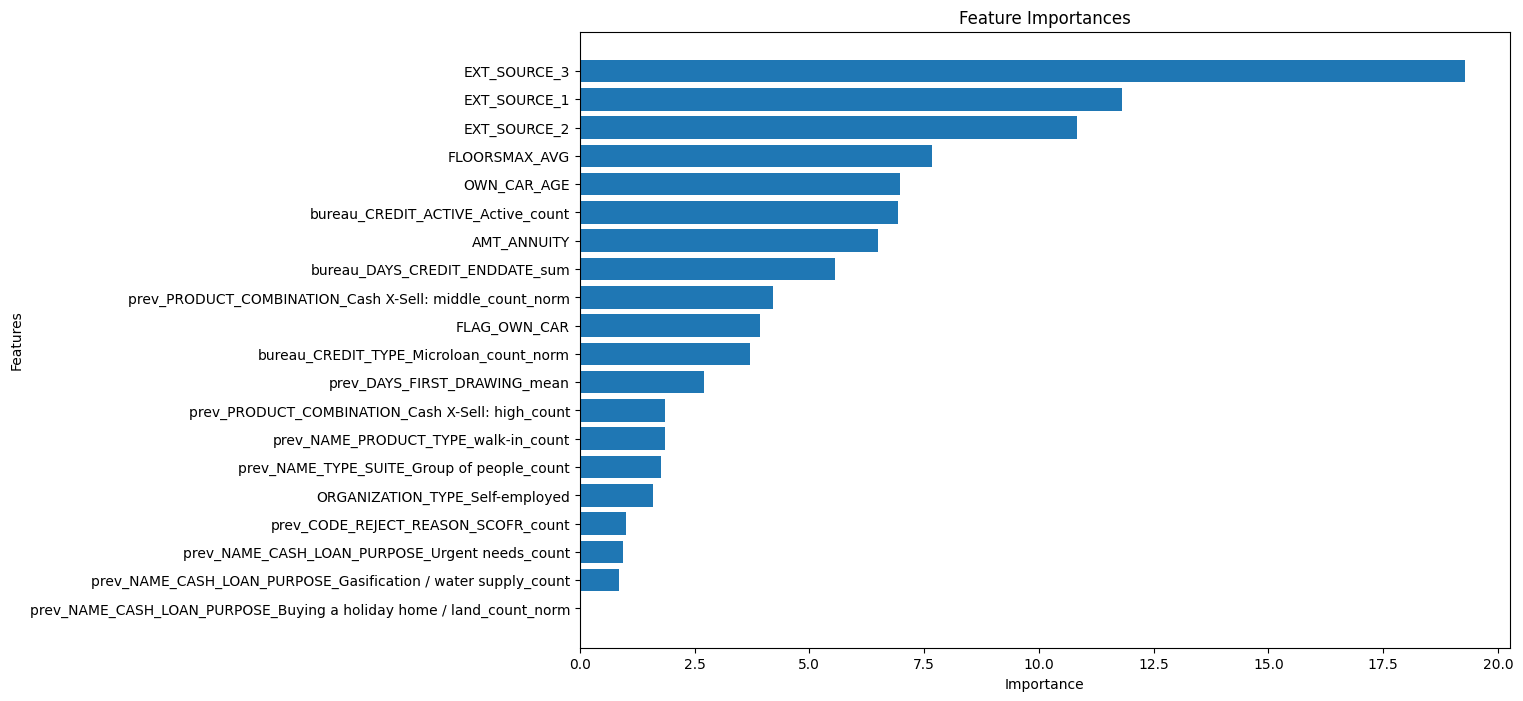

{'learn': {'Accuracy:use_weights=true': 0.9184495460321506,
  'Logloss': 0.28491592534218,
  'Precision:use_weights=true': 0.889920923917156,
  'F1:use_weights=true': 0.9213275853998985,
  'Recall:use_weights=true': 0.9550321199143469},
 'validation': {'NormalizedGini:use_weights=true': 0.5558721549636805,
  'Accuracy:use_weights=true': 0.713125798928729,
  'Logloss': 0.5778726401513341,
  'Precision:use_weights=true': 0.7943970214957469,
  'F1:use_weights=true': 0.7094145682690319,
  'Recall:use_weights=true': 0.68,
  'AUC': 0.7779360774818402}}

In [35]:
# Замерим метрики на отобранных таким образом фичах (20 фич)
# Создадим классификатор для задачи

catboost_model = CatBoostClassifier(
    iterations=200,  # Modify this parameter as needed
    thread_count=8, 
    custom_metric = ['F1:use_weights=true', 
                     'Precision:use_weights=true', 
                     'Recall:use_weights=true', 
                     'Accuracy:use_weights=true', 
                     'NormalizedGini:use_weights=true'],
    eval_metric='AUC',  # Changed to AUC
    auto_class_weights='Balanced' ,
    verbose=100,  # Output the training process every 100 iterations
    random_seed=42,
    
)


X = outliers_data[selected_features]
y = outliers_data["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)


# Установочный запуск + иницииализация параметров
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)


# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()
catboost_model.get_best_score()

In [30]:
y_pred = catboost_model.predict_proba(X_test)[:, 1]

wandb.init(
        project=project_name, name=exp_name+"3"+"_mRMR_15"
    )  # Инициализация эксперимента, project - название проекта
wandb.log(
    {
        "accuracy_score": accuracy_score(y_true=y_test, y_pred=catboost_model.predict(X_test)),
        "f1_score_weighted": f1_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "precision_weighted": precision_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "roc_auc_score": roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted"),
        "gini": 2 * roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted") - 1
    }
)
wandb.sklearn.plot_roc(y_true = y_test, y_probas = catboost_model.predict_proba(X_test))
#wandb.sklearn.plot_class_proportions(y_train, y_test)
wandb.finish()

accuracy_score,▁
f1_score_weighted,▁
gini,▁
precision_weighted,▁
roc_auc_score,▁
accuracy_score,0.75342
f1_score_weighted,0.81763
gini,0.56318
precision_weighted,0.9249
roc_auc_score,0.78159


### Циклический катбуст ухудшает метрику, поэтому в mRMR его использовать не будем. Пример (20 фич):

In [12]:
# Create a pandas dataframe for easier visualization
def create_importance_df(X_train, feature_importances):
    importance_df = pd.DataFrame({
        'Features': X_train.columns,
        'Importance': feature_importances
    })
    
    # Sort the dataframe based on the feature importances
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    return importance_df

# Get feature importances
def get_feature_importances():
    feature_importances = catboost_model.get_feature_importance()
    importance_df = importance_df_dr

    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Features'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

Learning rate set to 0.129448
0:	test: 0.7328644	best: 0.7328644 (0)	total: 5.48ms	remaining: 1.09s
100:	test: 0.7671157	best: 0.7761608 (22)	total: 508ms	remaining: 498ms
199:	test: 0.7706954	best: 0.7761608 (22)	total: 991ms	remaining: 0us

bestTest = 0.7761607748
bestIteration = 22

Shrink model to first 23 iterations.
Learning rate set to 0.129448
0:	test: 0.7377162	best: 0.7377162 (0)	total: 5.09ms	remaining: 1.01s
100:	test: 0.7735254	best: 0.7787506 (38)	total: 498ms	remaining: 489ms
199:	test: 0.7543496	best: 0.7787506 (38)	total: 983ms	remaining: 0us

bestTest = 0.7787506053
bestIteration = 38

Shrink model to first 39 iterations.
Learning rate set to 0.129448
0:	test: 0.7236082	best: 0.7236082 (0)	total: 5.36ms	remaining: 1.07s
100:	test: 0.7751816	best: 0.7763797 (91)	total: 480ms	remaining: 470ms
199:	test: 0.7650809	best: 0.7763797 (91)	total: 931ms	remaining: 0us

bestTest = 0.776379661
bestIteration = 91

Shrink model to first 92 iterations.


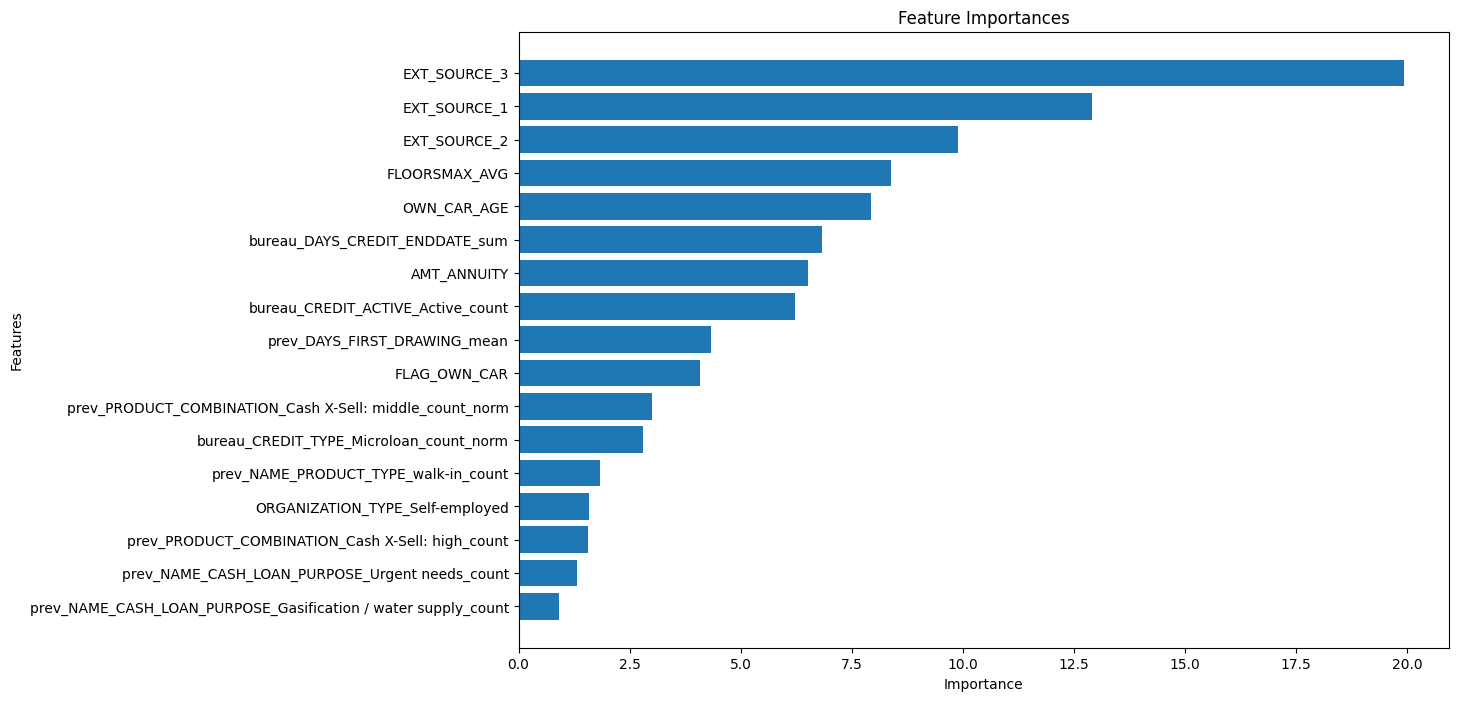

{'learn': {'Accuracy:use_weights=true': 0.9213298725063049,
  'Logloss': 0.2824222072070242,
  'Precision:use_weights=true': 0.8900290791221704,
  'F1:use_weights=true': 0.9243648268317424,
  'Recall:use_weights=true': 0.961456102783726},
 'validation': {'NormalizedGini:use_weights=true': 0.5527593220338982,
  'Accuracy:use_weights=true': 0.7127493230927046,
  'Logloss': 0.5791996475573348,
  'Precision:use_weights=true': 0.7944499169844789,
  'F1:use_weights=true': 0.7151210685487706,
  'Recall:use_weights=true': 0.736,
  'AUC': 0.7763796610169491}}

In [34]:
importance_df_dr = importance_df
features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
train_dropped = outliers_data[selected_features].drop(columns=features_to_drop)



while len(importance_df_dr[importance_df_dr["Importance"] <= 0.5]) > 0:
   
    X_dr = train_dropped
    y_dr = outliers_data["TARGET"]
    
    X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(X_dr, y_dr, 
                                                        random_state=42, 
                                                        test_size=0.2)
    
    # Fit model
    catboost_model.fit(X_train_dr, y_train_dr, eval_set=(X_test_dr, y_test_dr), use_best_model=True)
    feature_importances_dr = catboost_model.get_feature_importance()
    importance_df_dr = create_importance_df(X_train_dr, feature_importances_dr)
    features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
    train_dropped = train_dropped.drop(columns=features_to_drop)
get_feature_importances()
catboost_model.get_best_score()

### Выводы
mRMR показывает худшее качество, по сравнению с permutation, хотя и позволяет сохранить интерпретируемость фич. Как лучший результат для тюнинга способ не подходит.

In [36]:
best_features = importance_df_dr["Features"]
best_features.to_csv("3_best_features_mRMR_out.csv", index=False)
outliers_data[selected_features].to_csv("3_best_features_mRMR.csv", index=False)